In [1]:
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Activation
from keras            import initializers;
from keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def create_model(state_size, action_size, learning_rate=0.01):
    initializer = initializers.random_uniform(0, 0.1, seed=1)
    model = Sequential()
    model.add(Dense(action_size, input_dim=state_size,
                    activation='softmax', kernel_initializer=initializer))
    
    model.compile(loss='mse', optimizer=Adam(learning_rate))
    return model

In [3]:
class Agent():
    
    def __init__(self, env):
        
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.brain = create_model(self.state_size, self.action_size)
        self.memory = deque(maxlen=2000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.gamma = 0.95
        
    def next_action(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        actions = self.brain.predict(state)[0]
        #print(actions)
        return np.argmax(actions)
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
                return
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = self.brain.predict(state)
            if not done:
                target[0][action] = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            else:
                target[0][action] = reward
            self.brain.fit(state, target, epochs=1, verbose=0)

        self.decay_exploration_rate()
                
    def decay_exploration_rate(self):
        self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay) 
    
    def learn(self, num_episodes, max_step_by_episode=200, batch_size=32):
        win = []
        steps = []
        for i in tqdm(range(num_episodes)):
            state = env.reset()
            state = np.identity(16)[state:state+1]
            nb_steps_this_episode = 0
            done = False
            while not done:
                action = self.next_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.identity(16)[next_state:next_state+1]
                self.remember(state, action, reward, next_state, done)
                nb_steps_this_episode += 1
                if done:
                    break
                state = next_state
            win.append(reward)
            steps.append(nb_steps_this_episode)
            self.replay(batch_size)
        return win, steps
     

100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


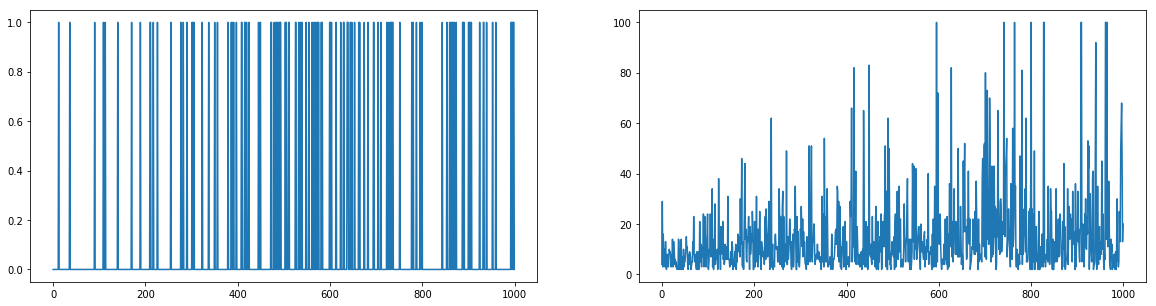

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake-v0')
agent = Agent(env)
win, steps = agent.learn(1000)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(win)
plt.subplot(1,2,2)
plt.plot(steps)

In [7]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames, actions):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print("Timestep:%s" % (i + 1))
        print("State: %s" % frame['state'])
        print("Action:  %s" % actions[frame['action']])
        print("Reward:  %s" % frame['reward'])
        sleep(0.5)

In [8]:
def play_policy(env, model):
    s = env.reset()
    d = 0
    frames = []
    while not d:
        Q = model.predict(np.identity(16)[s:s+1])
        a = np.argmax(Q)
        s, r, d, _ = env.step(a)
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': s,
            'action': a,
            'reward': r
            })
    return frames        

In [9]:
frames = play_policy(env,agent.brain)
actions = {0: '\u2190', 1: '\u2193', 2: '\u2192', 3: '\u2191'}
print_frames(frames, actions)

  (Left)
SFFF
FHFH
FFFH
HFFG

Timestep:2
State: 5
Action:  ←
Reward:  0.0
